<h1> Lab - Dataset Alcohol </h1>
<p> Build a classifier for dataset alcohol.</p>


In [153]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [155]:
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DatFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

# Class, for use in pipelines, to impute missing values but which overcomes a problem that scikit-learn's class has
# when imputing modes on nominal-valued features
# From https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
# Original has a casting problem
# Fixed by Derek Bridge 2017
class MissingValueImputer(Imputer):
    def __init__(self, **kwargs):
        Imputer.__init__(self, **kwargs)
    def fit(self, X, y=None):
        if self.strategy == "most_frequent":
            self.fills = pd.DataFrame(X).mode(axis=0).squeeze() 
            return self
        else:
            return Imputer.fit(self, X, y=y)
    def transform(self, X):
        if hasattr(self, "fills"):
            return pd.DataFrame(X).fillna(self.fills).values
        else:
            return Imputer.transform(self, X)

In [156]:
#read the data from file
df = pd.read_csv('datasets/dataset_alcohol.csv')

In [157]:
df.shape

(76, 9)

In [158]:
df.columns


Index(['age_yrs', 'height_cm', 'weight_kg', 'duration_mins', 'elapsed_mins',
       'sex', 'last_meal', 'units', 'over_limit'],
      dtype='object')

In [159]:
df.dtypes

age_yrs            int64
height_cm          int64
weight_kg          int64
duration_mins     object
elapsed_mins      object
sex               object
last_meal         object
units            float64
over_limit        object
dtype: object

In [160]:
df.describe(include='all')

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
count,76.000000,76.000000,76.000000,76,76,76,76,76.000000,76
unique,NaN,NaN,NaN,16,9,2,5,NaN,2
top,NaN,NaN,NaN,120,10,Male,Full,NaN,No
freq,NaN,NaN,NaN,15,61,60,33,NaN,46
mean,22.657895,176.644737,71.486842,NaN,NaN,NaN,NaN,8.632895,NaN
std,5.627439,8.453329,11.474602,NaN,NaN,NaN,NaN,5.775567,NaN
min,18.000000,157.000000,47.000000,NaN,NaN,NaN,NaN,0.000000,NaN
25%,19.000000,172.000000,63.000000,NaN,NaN,NaN,NaN,4.275000,NaN
50%,21.000000,177.000000,72.000000,NaN,NaN,NaN,NaN,8.400000,NaN
75%,23.000000,182.000000,79.000000,NaN,NaN,NaN,NaN,12.100000,NaN


In [161]:
df

,age_yrs,height_cm,weight_kg,duration_mins,elapsed_mins,sex,last_meal,units,over_limit
0,40,170,75,?,?,Male,Lunch,0.0,No
1,26,177,76,60,10,Male,Full,2.9,No
2,24,160,60,60,10,Female,Full,2.6,No
3,29,160,63,90,10,Female,Full,1.2,No
4,23,182,63,120,10,Male,Full,5.2,No
5,19,165,51,120,10,Female,Lunch,5.2,Yes
6,20,185,66,120,10,Male,Snack,5.2,No
7,23,185,84,150,10,Male,Lunch,15.0,No
8,23,170,66,60,30,Male,?,4.5,No
9,18,177,82,60,10,Male,Full,2.6,No


<p><font size="4"><b>Data preparation</b></font></p>
<p> Clean the dataset. Look after for dummy values. </p>


In [162]:
df = (df[df['duration_mins']!='?']).copy()
df.reset_index(drop=True, inplace=True)

In [163]:
df = (df[df['elapsed_mins']!='?']).copy()
df.reset_index(drop=True, inplace=True)

In [164]:
df['age_yrs'].unique()

array([26, 24, 29, 23, 19, 20, 18, 25, 21, 28, 36, 39, 22, 34, 45, 38])

In [165]:
df['height_cm'].unique()

array([177, 160, 182, 165, 185, 170, 187, 172, 157, 180, 167, 175, 162, 200])

In [166]:
df['weight_kg'].unique()

array([ 76,  60,  63,  51,  66,  84,  82,  71,  79,  57,  88,  47,  72,
        73,  69, 101,  64,  53,  75,  52,  55,  48,  95,  80,  85])

In [167]:
df['duration_mins'].unique()

array(['60', '90', '120', '150', '240', '30', '270', '180', '330', '435',
       '325', '300', '360', '315', '5'], dtype=object)

In [168]:
df['duration_mins'] = df['duration_mins'].astype(int)

In [169]:
df['duration_mins'].unique()

array([ 60,  90, 120, 150, 240,  30, 270, 180, 330, 435, 325, 300, 360,
       315,   5])

In [170]:
df['elapsed_mins'].unique()

array(['10', '30', '5', '60', '40', '120', '15', '180'], dtype=object)

In [171]:
df['elapsed_mins'] = df['elapsed_mins'].astype(int)

In [172]:
df['elapsed_mins'].dtype


dtype('int64')

In [173]:
df['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [174]:
df['last_meal'].unique()

array(['Full', 'Lunch', 'Snack', '?', 'None'], dtype=object)

In [175]:
(df['last_meal']=='?').sum()

1

In [176]:
(df['last_meal']=='None').sum()


11

In [177]:
df.shape

(74, 9)

In [178]:
df = (df[df['last_meal']!='?']).copy()
df.reset_index(drop=True, inplace=True)

In [179]:
df.shape

(73, 9)

In [180]:
df['units'].unique()

array([  2.9,   2.6,   1.2,   5.2,  15. ,   2.4,  10. ,   9.6,   5. ,
        12.6,   1.3,  16.1,  10.1,   5.1,   9.8,   9. ,  11.4,  13.2,
        13.6,   4.6,  16.9,  10.4,  15.8,  10.2,   9.1,   5.9,  12. ,
        31.2,  20.8,  11. ,  16.8,  12.4,   7.2,  13. ,   7.8,   9.5,
        15.6,  14.4,   3. ,  19.7,  16.6,   3.6,   4.8])

<p>Dataset after the cleaning process</p>

In [181]:
#Professor's method
#for col in ['duration_mins','elapsed_mins','sex','last_meal','over_limit']:
#   print(col, (df[col] == '?').sum())


<p><b>Imputting(Imputter class) the  the mean or the mode where are missing values is a good idea instead of delete them, but we should be careful, it's not always the case(here is not the case to impute values for the duration_mins and elapsed_mins, but for the last_meal we can).</b></p>

In [182]:
#randomize the data(here is not really the case because the data seem to be random)
df = df.take(np.random.permutation(len(df)))
df.reset_index(inplace=True, drop=True)

<p><font size="4"><b>Build the classifier</b></font></p>

In [183]:

y = df["over_limit"].values

encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

In [184]:
#The features we want to select
numeric_features = ["age_yrs","height_cm","weight_kg","duration_mins","elapsed_mins","units"]
nominal_features = ["sex", "last_meal"]

numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features)),
        ("scaler", StandardScaler())
    ])

nominal_pipeline = Pipeline([
        ("selector", DataFrameSelector(nominal_features)), 
        ("binarizer", FeatureBinarizer([df[feature].unique() for feature in nominal_features]))])

#Create two different classifiers

ovr_pipeline = Pipeline([("union", FeatureUnion([("numeric_pipeline", numeric_pipeline), 
                                             ("nominal_pipeline", nominal_pipeline)])),
                         ("estimator", LogisticRegression())])

dummy_pipeline = Pipeline([("union", FeatureUnion([("numeric_pipeline", numeric_pipeline), 
                                             ("nominal_pipeline", nominal_pipeline)])),
                         ("estimator", DummyClassifier(strategy = "most_frequent"))])

In [213]:
ss = ShuffleSplit(n_splits=4, train_size=0.8)
np.mean(cross_val_score(ovr_pipeline, df, y_encoded, scoring="accuracy", cv=ss))

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1630: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.71875

In [212]:
#Accuracy of the first classifier
#Pay attention to cv variable, we only have 76 examples and we should have at least 30 in a fold.
np.mean(cross_val_score(ovr_pipeline, df, y_encoded, scoring="accuracy", cv=3))

0.76777777777777778

In [186]:
#Accuracy of the second classifier
np.mean(cross_val_score(dummy_pipeline, df, y_encoded, scoring="accuracy", cv=3))

0.58888888888888891

In [187]:
#Confusion matrix
y_predicted = cross_val_predict(pipeline, df, y, cv=3) 
confusion_matrix(y, y_predicted)

array([[34,  9],
       [ 8, 22]])

<p>Duplicate values if confusion matrix has predict wrong a lot.</p>

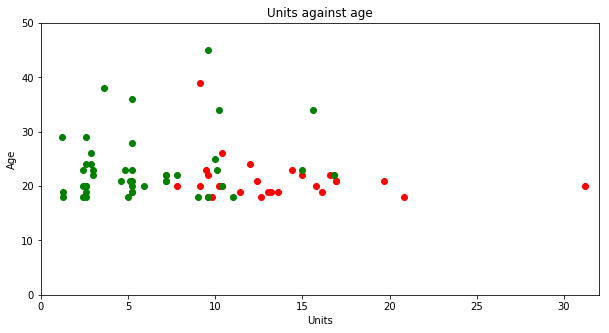

In [188]:

units = df['units']
age = df['age_yrs']
over_limit = df["over_limit"]

fig = plt.figure(figsize=(10,5))
plt.title("Units against age")
plt.scatter(units[over_limit=="Yes"], age[over_limit=="Yes"], color = "red")
plt.scatter(units[over_limit=="No"], age[over_limit=="No"], color = "green")
plt.xlabel("Units")
plt.xlim(0, 32)
plt.ylabel("Age")
plt.ylim(0, 50)
plt.show()